# Creating sediment input into Landlab NetworkSedimentTransporter component

#### This jupyter notebook was created by graduate students as part of the 2021 CSDMS ESPIn (Earth Surface Processes Institute).

# The NST-notebook

Unfortunately we could not run it without errors yet. It’s still in a development stage,
It still needs some work. We present here the overall modeling framework linking multiple Landlab components, and demonstrate how to add variable sediment sources in the NST model. 

#### Creators
Marius Huber - CNRS, Université de Lorraine

Mel Guirro - Durham University

Muneer Ahammad - VT

Se Jong Cho - USGS 

With help from Shelby Ahrendt - University of Washington


## Notebook Overview
This notebook is the second part of the 'Slope and Channels' group of 2021 CSDMS ESPIn.
The first part used Landlab SPACE component to evaluate how fire or landslide would increase sediment availability from hillslopes into channels. You can check the first part here: 

This second part will synthetically introducte the increased sediment availability from fire or landslide at atjacent nodes and
use the Landlab NetworkSedimentTransporter component to run the sediment through the river network.

The goal is to verify if the sediment yield at watershed outlet is different when simulated by NetworkSedimentTransporter when compared to SPACE, as each component reproduce sediment transport with different physical background.


### Modeling Objectives
1. Couple the river network from SPACE to NetworkSedimentTransporter, by creating the river network model grid from landscape grid created from SPACE.
2. Run the NetworkSedimentTransporter.
3. Compare the results from SPACE and NetworkSedimentTransporter, to analyse how each component represents sediment transport.

### Landlab Components used
Space
NetworkSedimentTransporter

## Conceptual Model


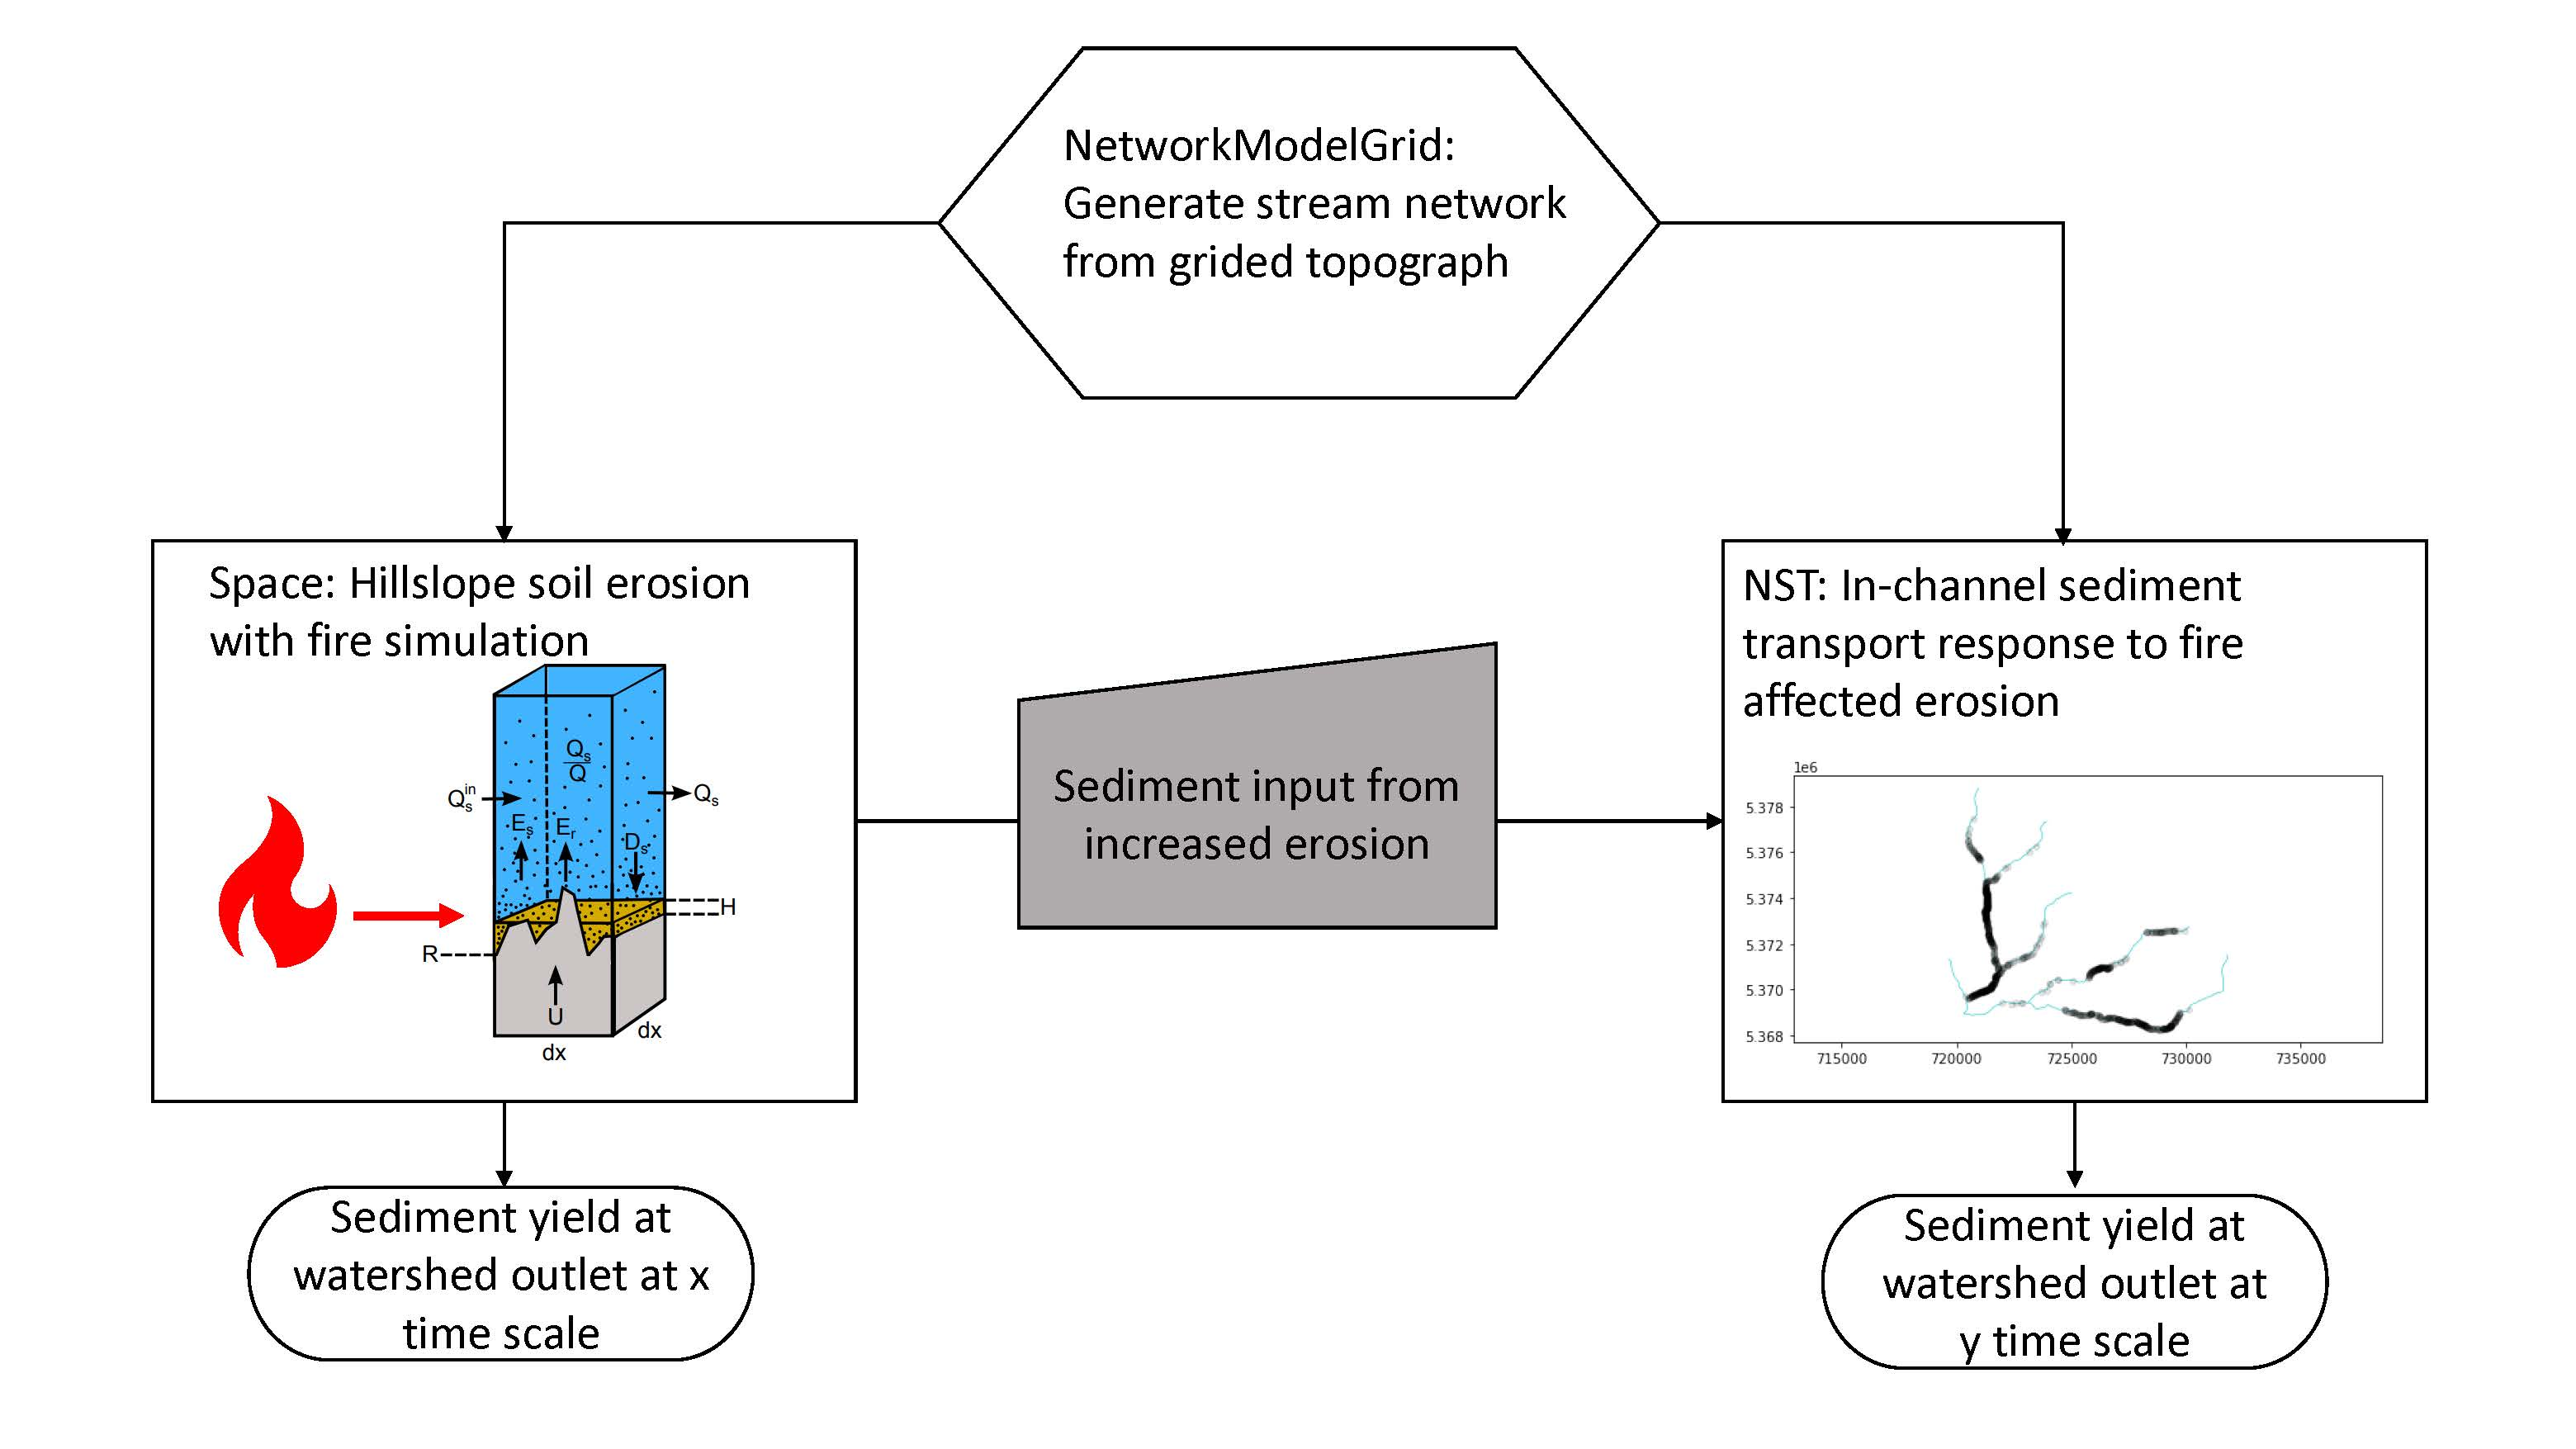

## Load the necessary packages

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab.plot import plot_network_and_parcels


import os
from landlab.io import read_esri_ascii
import landlab.plot.colors
from landlab import (RasterModelGrid,
                     imshow_grid)

%matplotlib inline

## Create the river network model grid from landscape grid created from SPACE

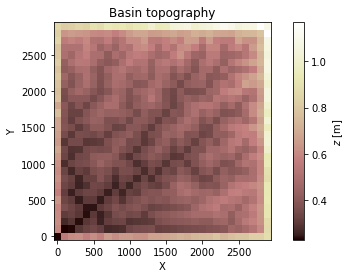

In [2]:
#Fetch DEM ascii
slopeChannel_dir = os.path.dirname('/home/marius/Documents/Doctorat/ESPIn/slopes-channels/') #NEED TO ENTER CORRECT DIRECTORY!!!
#raster_fn = os.path.join(tutorial_dir, 'overland_flow/hugo_site.asc') #mac
raster_fn = os.path.join(slopeChannel_dir, 'exampleDEM.asc') #windows

#define landcape grid
mg, z = read_esri_ascii(raster_fn, name='exampleDEM')
_ = mg.add_zeros('topographic__elevation', at='node')
mg.at_node['topographic__elevation'] =z
#rmg.status_at_node[rmg.nodes_at_right_edge] = rmg.BC_NODE_IS_FIXED_VALUE
#rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED

##topographic__elevation=z

#plot dem
plt.figure(figsize=(8,4))
imshow_grid(mg, 'exampleDEM',
            plot_name="Basin topography",
            color_for_closed=None,
            colorbar_label="$z$ [m]")
plt.show()

### Define function "create_network_from_raster"


It would be nice if that function can be stored seperately (not in this notebook). Need to figure out how this is done in python, jupyter. No time :/


In [3]:
# from landlab.grid.create_network import create_network_from_raster #(this does not work!!!)

In [4]:
#author: sahrendt


from landlab.components import ChannelProfiler, FlowAccumulator, DepressionFinderAndRouter
from landlab.graph import NetworkGraph
from landlab.grid.raster import RasterModelGrid
from landlab.grid.network import NetworkModelGrid


def create_network_from_raster(
        rmg, min_channel_thresh=10000, outlet_nodes=None, method='variable',
        n_widths=20, a=9.68, b=0.32, d_node_spacing=None, fields=None):
    """Create a NetworkModelGrid from a RasterModelGrid. Default behavior
    spaces nodes a certain number of local channel widths apart across the
    network. If method='constant' is specified, the d_node_spacing value
    is used to space nodes a constant distance apart across the network.
    Parameters
    ----------
    rmg : RasterModelGrid object
        A raster grid used to create a network grid
    min_channel_thresh : float, optional
        Value to use for the minimum drainage area associated with a
        plotted channel segment from the ChannelProfiler. Default values 10000.
    outlet_nodes : Single int value in iterable form, optional
        Iterable containing the node ID of nodes to start the channel profiles
        from in ChannelProfiler. If not provided, the default is the node ID on
        the model grid boundary with the largest terminal drainage area.
    method : string, 'variable' or 'constant'
        Specifies node-spacing method. 'variable' will dynamically update
        node spacing depending on local channel width. 'constant' will use the
        specified 'node_spacing' value to space nodes evenly across the
        network.
    n_widths : float, optional
        Multiplier to define node spacing as a function of local channel width.
    a : float, optional
        Parameter to be used in the Frasson et al. 2019 (GRL) power
        relationship between drainage area and channel width W=a*A^b. Default
        is value is 9.68 from Frassen et. al 2019
    b : float, optional
        Parameter to be used in the Frasson et al. 2019 (GRL) power
        relationship between drainage area and channel width W=a*A^b. Default
        is value is 0.32 from Frassen et. al 2019
    d_node_spacing : float, optional
        Distance value for a constant node spacing along channel segments.
        Must be provided if method is 'constant'.
    fields : iterable, optional
        .at_node fields to map from RasterModelGrid to NetworkModelGrid.
        Formatted as strings inside an iterable object

    Returns
    -------
    NetworkModelGrid object with .at_node['rmg_node_value'] attribute
    listing the RasterModelGrid node ids at each NetworkModelGrid node.
    """

    if 'drainage_area' not in rmg.at_node:
        # run flow accumulator for ChannelProfiler
        fa = FlowAccumulator(rmg,
                             'topographic__elevation',
                             flow_director='D8',
                             depression_finder='DepressionFinderAndRouter')
        fa.run_one_step()

    # delinate channel
    profiler = ChannelProfiler(
        rmg,
        number_of_watersheds=1,
        minimum_channel_threshold=min_channel_thresh,
        outlet_nodes=outlet_nodes,
        main_channel_only=False,
    )
    profiler.run_one_step()

    # obtain watershed key (should only be one)
    wtrshd_key = [k for k in profiler.data_structure.keys()][0]
    # obtain keys for channel segments, keys are raster nodes formated as
    # tuple for (start, end) for channel segment start and end locations
    channel_segment_keys = profiler.data_structure[wtrshd_key].keys()

    # IDENTIFY CHANNEL SEGMENT CONNECTIVITY -----------------------------------
    # obtain node ids for start and end of every channel segments
    seg_starts = [seg[0] for seg in profiler.data_structure[wtrshd_key].keys()]
    seg_ends = [seg[1] for seg in profiler.data_structure[wtrshd_key].keys()]
    # identify channel connectivity and how to properly link nodes
    # at different channel junctions
    # code currently identifies the key of the channel seg just downstream
    # and connects first node of upstream channel to downstream channel
    for i, seg_key in enumerate(channel_segment_keys):
        connectivity = []
        connectivity_key = None
        seg_i = profiler.data_structure[wtrshd_key][seg_key]
        # if the start of a segment is the end of another segment
        if seg_key[0] in seg_ends:
            connectivity.append('connected downstream')
            # find first segment downstream that should connect to last node of
            connect_to_channel_idx = np.argmax(seg_key[0] == seg_ends)
            connectivity_key = (seg_starts[connect_to_channel_idx],
                                seg_ends[connect_to_channel_idx])
        # if end of segment is in start of another segment
        if seg_key[-1] in seg_starts:
            connectivity.append('connected upstream')

        seg_i['connectivity'] = connectivity
        seg_i['connectivity_key'] = connectivity_key

    node_xy = []  # empty list to store paired x,y locations of nmg nodes
    rmg_nodes = []  # empty list to store raster model grid node corresponding to each network model grid node
    links = []  # empty list to store link connections between nodes

    # FUNCTION TO ADD LINKS----------------------------------------------------
    # this is called several times in loop below, and makes testing easier
    def add_link(rmg, all_nodes_xy, all_links, head_node_rmg_id,
                 tail_node_rmg_id):

        """Add link connections to existing list of NetworkModelGrid nodes
        based upon an upstream and downstream RasterModelGrid node id. Also
        checks whether (x, y) values for upstream and downstream nodes exist
        in list of node locations and adds them if necessary.

        Parameters
        ----------
        rmg : RasterModelGrid object
            The RasterModelGrid to which NetworkModelGrid nodes and links will
            be added.
        all_nodes_xy : list of tuples
            List where tuple values for node x and y locations formatted as
            [(x1,y1), (x2,y2)...] already exist or will be stored.
        all_links : list of tuples
            List where tuple values for NetworkModelGrid node ids of upstream
            and downstream nodes for each link already exists or will be
            stored. Formatted as [(id2, id1),(id3, id2)...] where id# '#'
            corresponds to the index of the node entry in all_nodes_xy.
        head_node_rmg_id : int
            Value of the RasterModelGrid node id that corresponds to the
            desired head node of a NetworkModelGrid link.
        tail_node_rmg_id : int
            Value of the RasterModelGrid node id that corresponds to the
            desired head node of a NetworkModelGrid link.
        Returns
        -------
        None.
        """
        # define head node xy value by calling id from raster model grid
        head_node_xy = (rmg.x_of_node[head_node_rmg_id],
                        rmg.y_of_node[head_node_rmg_id])
        # define a tail node xy value by calling id from raster model grid
        tail_node_xy = (rmg.x_of_node[tail_node_rmg_id],
                        rmg.y_of_node[tail_node_rmg_id])
        # if these nodes don't already exist in the array of node xy vals from
        # another channel segment, add them
        if head_node_xy not in all_nodes_xy:
            all_nodes_xy.append(head_node_xy)
        if tail_node_xy not in all_nodes_xy:
            all_nodes_xy.append(tail_node_xy)
        # get the index of the head and tail node from our node_xy list
        # this is important to do in case they were added from a previous
        # channel segment. we need to ensure the order of network nodes is
        # correct
        head_node__nmg_id = all_nodes_xy.index(head_node_xy)
        tail_node__nmg_id = all_nodes_xy.index(tail_node_xy)
        # append the head and tail network node ids to the link array
        all_links.append((head_node__nmg_id, tail_node__nmg_id))




        # CREATE NETWORK MODEL GRID NODES & LINKS----------------------------------

    # loop over all channel segments and add network model nodes
    for i, seg_key in enumerate(channel_segment_keys):

        # access data of channel segments
        seg_i = profiler.data_structure[wtrshd_key][seg_key]

        # create list to hold rmg node ids where nmg nodes are located
        nmg_nodes = []

        # identify rmg value of first node in segment
        # first nodes of channel segments will always be included in network
        # if they don't already exist
        idx_node = 0
        rmg_node = seg_i['ids'][idx_node]

        # if seg_i is connected dowstream, add link connecting first node of
        # segment to downstream node
        if seg_i['connectivity_key'] is not None:
            channel_key = seg_i['connectivity_key']
            connecting_seg = profiler.data_structure[wtrshd_key][channel_key]

            # check to make sure there are nmg nodes on downstream segment
            if len(connecting_seg['ids_nmg']) > 0:
                connect_node = connecting_seg['ids_nmg'][-1]

            # if there are no nmg nodes on the downstream segment
            # it must be too short for calculated node spacing
            # if this is the case, connect upstream segment to first node in
            # dowsntream connecting seg
            else:
                connect_node = connecting_seg['ids'][0]
            # add a link for this connection if necessary
            add_link(rmg, node_xy, links,
                     head_node_rmg_id=rmg_node,
                     tail_node_rmg_id=connect_node)

        # iterate over segment adding new nodes as long as there are upstream nodes
        # that can be placed on network model grid based upon node spacing
        upstrm_node = True
        while upstrm_node is True:

            # if we haven't already stored the rmg id value for this new node
            # add it to our master list of rmg nodes and sub-list of nmg nodes
            if rmg_node not in rmg_nodes:
                rmg_nodes.append(rmg_node)
                nmg_nodes.append(rmg_node)

            # Assign node spacing as n_channel_widths or a constant value from
            # input params
            #if method is 'variable':
            if method == 'variable':
                # calculate drainage area contributing to this node
                da_node = rmg.at_node['drainage_area'][rmg_node]
                # relate drainage area to river width (convert area to km, width in m)
                # from Frasson et al. 2019 GRL
                w_channel = (a * da_node / (1000 ** 2)) ** b
                # calculate upstream node spacing, n_widths_defines stable node spacing
                node_spacing = n_widths * w_channel
            #if method is 'constant':
            if method == 'constant':
                node_spacing = d_node_spacing

            # if stable node spacing is greater than raster grid resolution
            if node_spacing > rmg.dx:
                # optimal along-channel node location based upon node spacing
                opt_loc = seg_i['distances'][idx_node] + node_spacing
                # define tolerance to not add extra node if opt loc is within half
                # a node spacing away from end of segment
                buffer_tol = 0.5 * node_spacing

                # if we can fit another node on the channel segment
                if opt_loc < (seg_i['distances'][-1] - buffer_tol):
                    # find id of node closest to this location
                    idx_next_node = np.abs(seg_i['distances'] - opt_loc).argmin()
                    # update rmg node with whatever this next node should be
                    rmg_next_node = seg_i['ids'][idx_next_node]

                    # add link from this upstream node to the current node
                    # if necessary
                    add_link(rmg, node_xy, links,
                             head_node_rmg_id=rmg_next_node,
                             tail_node_rmg_id=rmg_node)

                    # update idx_node and rmg node for next loop
                    rmg_node = rmg_next_node
                    idx_node = idx_next_node

                # if no more nodes can be placed on this segment,
                # move to next segment
                else:
                    upstrm_node = False
                    # add last node in segment to list of node xys
                    last_node_xy = (rmg.x_of_node[rmg_node],
                                    rmg.y_of_node[rmg_node])
                    if last_node_xy not in node_xy:
                        node_xy.append(last_node_xy)

            # if no more nodes have stable locations on this segment
            # move to next segment
            else:
                upstrm_node = False

                # if we are seeing links on main stem channels that are smaller
                # then grid resolution, flag this and break code
                if 'connected upstream' in seg_i['connectivity']:
                    raise ValueError(
                        'main stem link lengths are smaller than grid res.' \
                        'try increasing n_widths or changing a and b params')

                # add last node in segment to list of node xys
                last_node_xy = (rmg.x_of_node[rmg_node],
                                rmg.y_of_node[rmg_node])
                if last_node_xy not in node_xy:
                    node_xy.append(last_node_xy)

        # store location of network nodes as raster model ids in channel profiler
        # datastructure. this will be used for joining channel segments later
        seg_i['ids_nmg'] = np.array(nmg_nodes)

    # CREATE NETWORK MODEL GRID OBJECT-----------------------------------------
    x_of_node, y_of_node = zip(*node_xy)

    # Maintain sorting by creating an unsorted network graph and sorting.
    # This process is important to ensure that the fields are assigned to the
    # correct links.
    graph_net = NetworkGraph((y_of_node, x_of_node), links=links, sort=False)
    sorted_nodes, sorted_links, sorted_patches = graph_net.sort()

    # use the sorting information to make a new network model grid.
    nmg = NetworkModelGrid(
        (np.asarray(y_of_node)[sorted_nodes], np.asarray(x_of_node)[sorted_nodes]),
        np.vstack((graph_net.node_at_link_head, graph_net.node_at_link_tail)).T
    )

    # add RMG node locations and extra fields to network model grid from
    # raster model grid
    nmg.at_node['rmg_node_value'] = np.array(rmg_nodes)[sorted_nodes]
    if fields is None:
        fields = []
    for field in fields:
        nmg.at_node[field] = rmg.at_node[field][nmg.at_node['rmg_node_value']]

    return (nmg)


### Create channel network grid from landscape grid
I wonder how this works, but it works :)


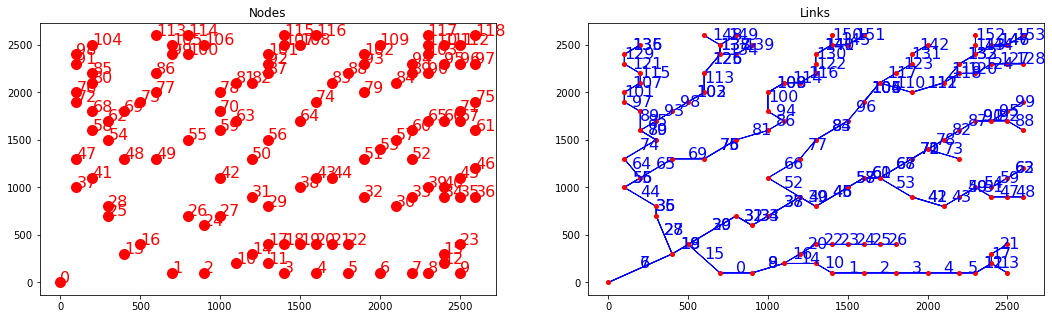

In [5]:
#create channel network grid from landscape grid from <Space team: minimalSpaceExample.ipynb>


dx = 100 #grid spacing? Is this correct? needs to be checked

nmg = create_network_from_raster(
    mg,
    method='variable', # method
    n_widths=dx,
    #node_spacing=30,
    #d_node_spacing=2*dx,
    min_channel_thresh=30000,
    fields=['drainage_area', 'topographic__elevation'])

from landlab.plot import graph

## Plot nodes
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
graph.plot_nodes(nmg)
plt.title("Nodes")

## Plot nodes + links
plt.subplot(1,2,2)
graph.plot_nodes(nmg,with_id=False,markersize=4)
graph.plot_links(nmg)
plt.title("Links")
plt.show()

### NST demonstration with simple stream network: adding variable sediment input
Following set up simple stream network and NST code revision

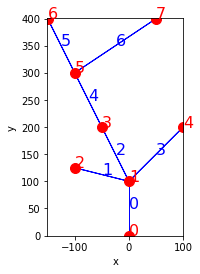

In [3]:
##Create simple river network model grid
##each link is the reach of the river connected by nodes

y_of_node = (0, 100, 200, 200, 300, 400, 400, 125)
x_of_node = (0, 0, 100, -50, -100, 50, -150, -100)
#
nodes_at_link = ((1, 0), (2, 1), (1, 7), (3, 1), (3, 4), (4, 5), (4, 6))
#
grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)
#
plt.figure(0)
graph.plot_graph(grid, at="node,link")
#
#Populate the grid with topographic information
#
grid.at_node["topographic__elevation"] = [0.0, 0.08, 0.25, 0.15, 0.25, 0.4, 0.8, 0.8]
grid.at_node["bedrock__elevation"] = [0.0, 0.08, 0.25, 0.15, 0.25, 0.4, 0.8, 0.8]
#
grid.at_link["flow_depth"] = 2.5 * np.ones(grid.number_of_links) # m
grid.at_link["reach_length"] = 200*np.ones(grid.number_of_links) # m
grid.at_link["channel_width"] = 1*np.ones(grid.number_of_links) # m

## Create sediment 'parcels' in a DataRecord

file:///home/marius/Documents/Doctorat/ESPIn/slopes-channels/NST/image.png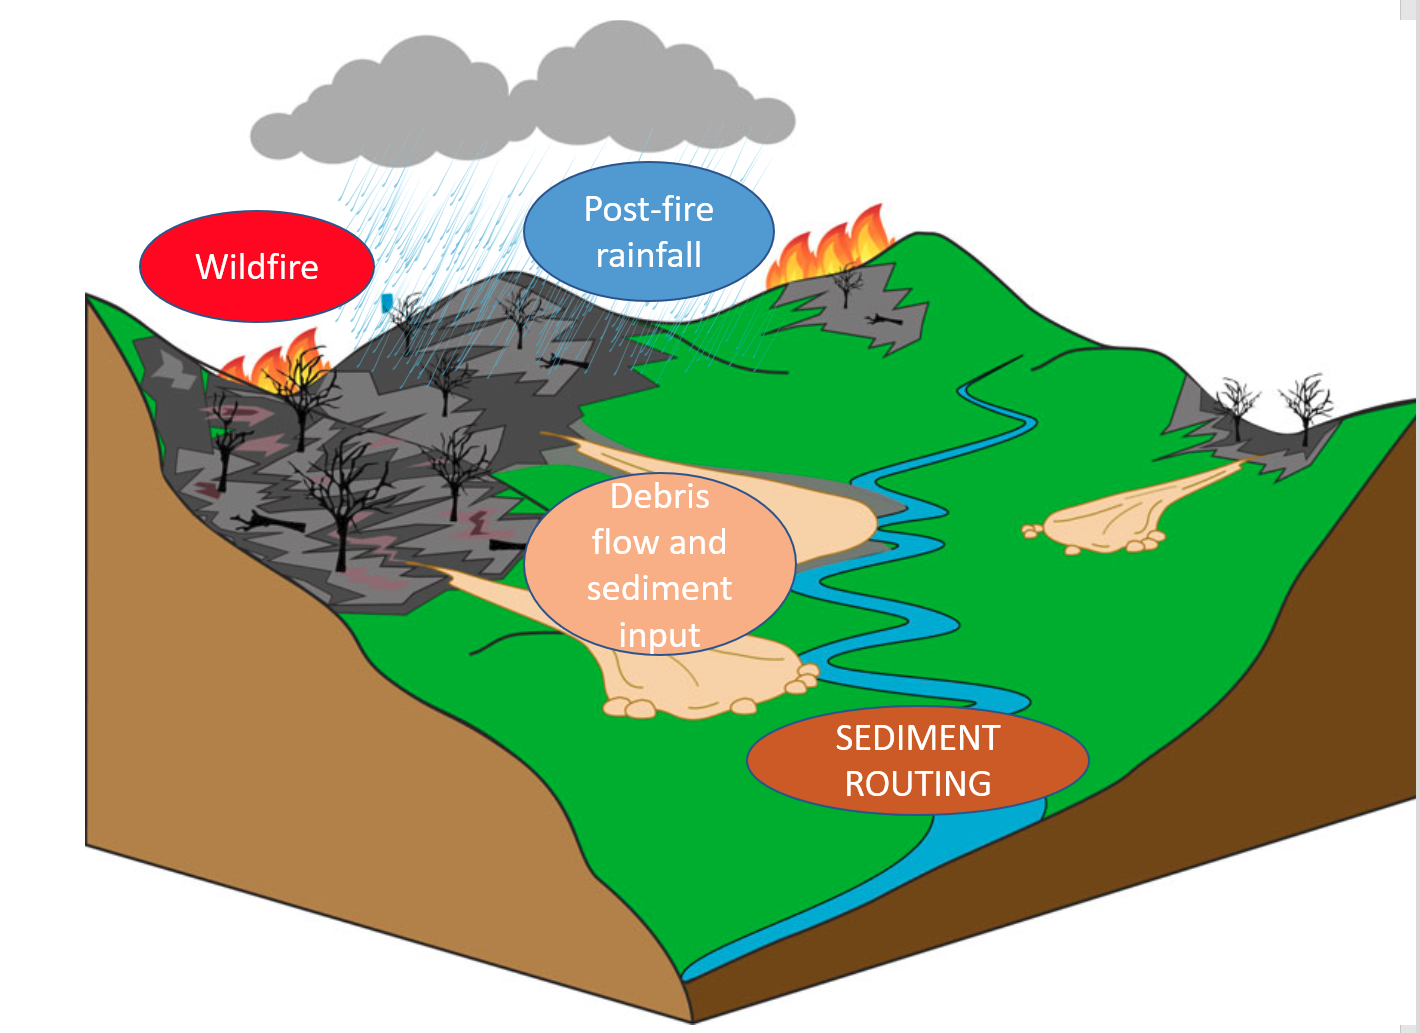

In [5]:
#Here we synthetically introduce increased sediment availability from fire or landslide at adjacent nodes
#Muneer's sediment parcel magic: v=additional volumes of sediment at different links

v=[0,2,4,7,8,0,5] #total volm (m^3):  main expected INPUT for all links
uv=0.05; #trial unit parcel volm

l=np.arange(grid.number_of_links)

n=np.array(v)/uv # no of parcels
print('Number of parcels in links:',n)



Number of parcels in links: [   0.   40.   80.  140.  160.    0.  100.]


In [6]:
# element_id is the link on which the parcel begins. 
#element_id = np.repeat(np.arange(nmg.number_of_links),30) #previous line: fixed 30 no of parcels in every link

element_id=[]
for i in l:

    element_id = np.concatenate((element_id, np.ones(int(n[i]))*i))
    
element_id=np.expand_dims(element_id, axis=1).astype('int')


In [7]:
volume = uv*np.ones(np.shape(element_id))  # (m3)  #unit volm*parcel no.=total input
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Lognormal GSD
medianD = 0.085 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

In [8]:
#Assign each parcel an arbirarry arrival time and location in the link

time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

In [9]:
# Define parcel characteristics
lithology = ["quartzite"] * np.size(element_id)

In [10]:
#Collect the arrays into a dictionary of variables to track them in space and time

variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}

In [11]:
#Create the parcels DataRecord

items = {"grid_element": "link", "element_id": element_id}

parcels = DataRecord(
    grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

## Run the Network Sediment Transporter

Unfortunately it does not run yet, because we couldn't define "parcels" correctly above.

In [12]:
#Set up NST model

timesteps = 10 # total number of timesteps
dt = 60 * 60 * 24 *1 # length of timestep (seconds) 

In [14]:
#calculate flow direction

fd = FlowDirectorSteepest(grid, "topographic__elevation")
fd.run_one_step()

In [15]:
#Initialize the NST

nst = NetworkSedimentTransporter(    
    grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

In [16]:
#Run model forward in time

for t in range(0, (timesteps * dt), dt):
    nst.run_one_step(dt)    
    print("Model time: ", t/dt, "timesteps passed")

Model time:  0.0 timesteps passed
Model time:  1.0 timesteps passed
Model time:  2.0 timesteps passed
Model time:  3.0 timesteps passed
Model time:  4.0 timesteps passed
Model time:  5.0 timesteps passed
Model time:  6.0 timesteps passed
Model time:  7.0 timesteps passed
Model time:  8.0 timesteps passed
Model time:  9.0 timesteps passed


## Plot the model results

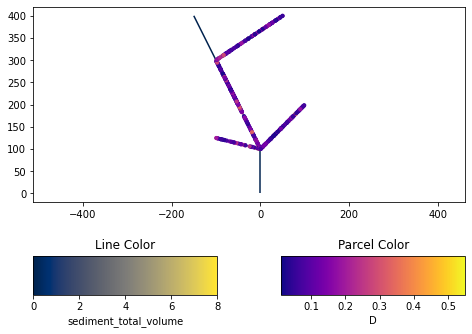

In [17]:
fig = plot_network_and_parcels(
    grid, parcels, 
    parcel_time_index=0, 
    parcel_color_attribute="D",
    link_attribute="sediment_total_volume", 
    parcel_size=10, 
    parcel_alpha=1.0)

Text(0, 0.5, 'Cumulative parcel travel distance')

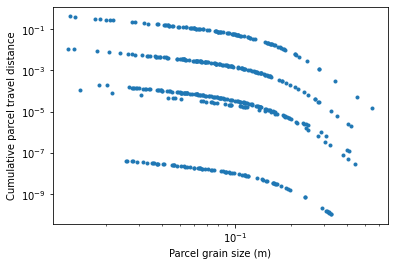

In [18]:
plt.loglog(parcels.dataset.D[:,-1],
         nst._distance_traveled_cumulative,
         '.'
        )
plt.xlabel('Parcel grain size (m)')
plt.ylabel('Cumulative parcel travel distance')

# Note: some of the smallest grain travel distances can exceed the length of the 
# grid by "overshooting" during a single timestep of high transport rate

## Conclusion
We presented a modeling framework linking multiple LandLab components to understand sediment dynamic in stream network resulting from landscape disturbances, such as randome fires, landslides, or landcover changes. In this example we showed how we might connect NST with SPACE, and with a simple stream network model we demonstrated how variable sediment inputs affect sediment transport throughout the stream network. 

Next steps are to complete the coupling of other Landlab components with NST to simulate complex stream network system. The modeling framework provides a foundation for exploring the instantaneous and long-term changes to sediment transport in the stream network. For example, HYLAND may be coupled with NST to examine the impact of landslide on downstream sediment flux. 